## 연어

### 시장별 가격 절대값의 시계열 의존성 확인

In [8]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [9]:

# CSV 읽기
df = pd.read_csv('연어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [10]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [11]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.005565
   강서농수산물시장       0.002537
   구리농수산물시장       0.001034
     노량진 1층       0.001080
     노량진 2층       0.002378
   마포농수산물시장       0.000184
  소래포구종합어시장       0.003752
   수원농수산물시장       0.001779
 안양평촌농수산물시장       0.001409
인천종합연안부두어시장       0.005208

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.942037   0.948478   0.951202   0.945089    0.936875
   강서농수산물시장   0.980869   0.977382   0.980467   0.971733    0.953775
   구리농수산물시장   0.990944   0.987396   0.984042   0.971607    0.946165
     노량진 1층   0.988641   0.984731   0.983056   0.972747    0.961632
     노량진 2층   0.981634   0.980074   0.981746   0.976533    0.968173
   마포농수산물시장   0.998636   0.997344   0.996113   0.990979    0.981599
  소래포구종합어시장   0.965156   0.961774   0.966828   0.950765    0.940299
   수원농수산물시장   0.972938   0.971597   0.9689

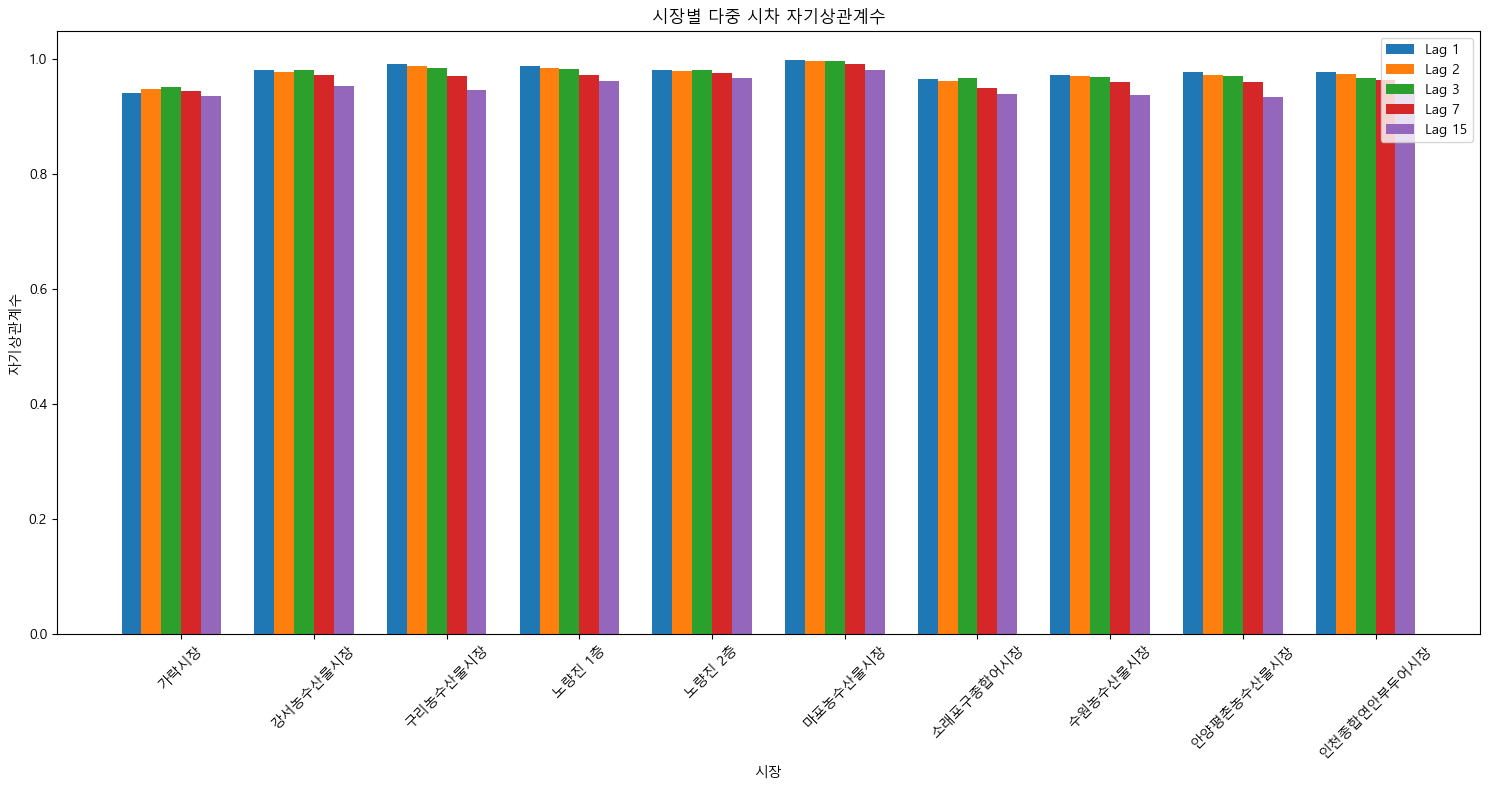

In [12]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

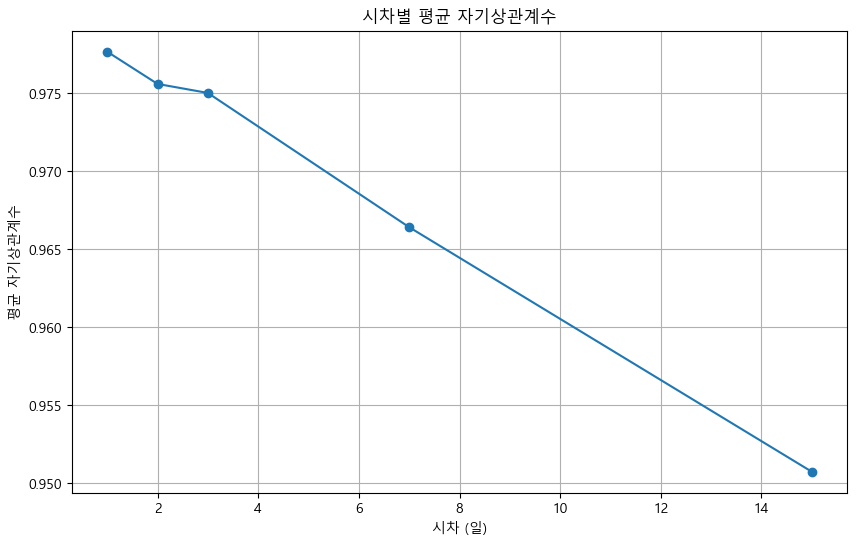

In [13]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

### 시장별 가격 변화율의 시계열 의존성 확인

In [10]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt

#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [11]:
# CSV 읽기
df = pd.read_csv('pp/연어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])

In [12]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
    
    # 일별 변화율 계산 (퍼센트)
    market_data['returns'] = market_data['avgPrice'].pct_change() * 100
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['returns'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['returns'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['returns'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data['returns'].dropna()),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
        
	# 변화율의 기본 통계량 추가
    result.update({
        'mean_return': market_data['returns'].mean()
    })
        
    results.append(result)

In [13]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 가격 변화율의 시계열 의존성 분석 결과 ===")

print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 가격 변화율의 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       3.027318
   강서농수산물시장       2.859280
   구리농수산물시장       2.579645
     노량진 1층       2.665704
     노량진 2층       2.824922
   마포농수산물시장       2.144261
  소래포구종합어시장       2.886618
   수원농수산물시장       2.950820
 안양평촌농수산물시장       2.787892
인천종합연안부두어시장       2.801799

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장  -0.515112   0.035607   0.061070   0.029750    0.073017
   강서농수산물시장  -0.430411  -0.163807   0.174179   0.043950   -0.083617
   구리농수산물시장  -0.290202  -0.006797  -0.043311  -0.005839   -0.015264
     노량진 1층  -0.333206  -0.051226   0.043480  -0.115397    0.163406
     노량진 2층  -0.413340  -0.066862   0.090474  -0.038547    0.102527
   마포농수산물시장  -0.072374  -0.037112   0.040548  -0.003816    0.047616
  소래포구종합어시장  -0.445085  -0.078748   0.207328  -0.013923   -0.070806
   수원농수산물시장  -0.476288   0.012216 

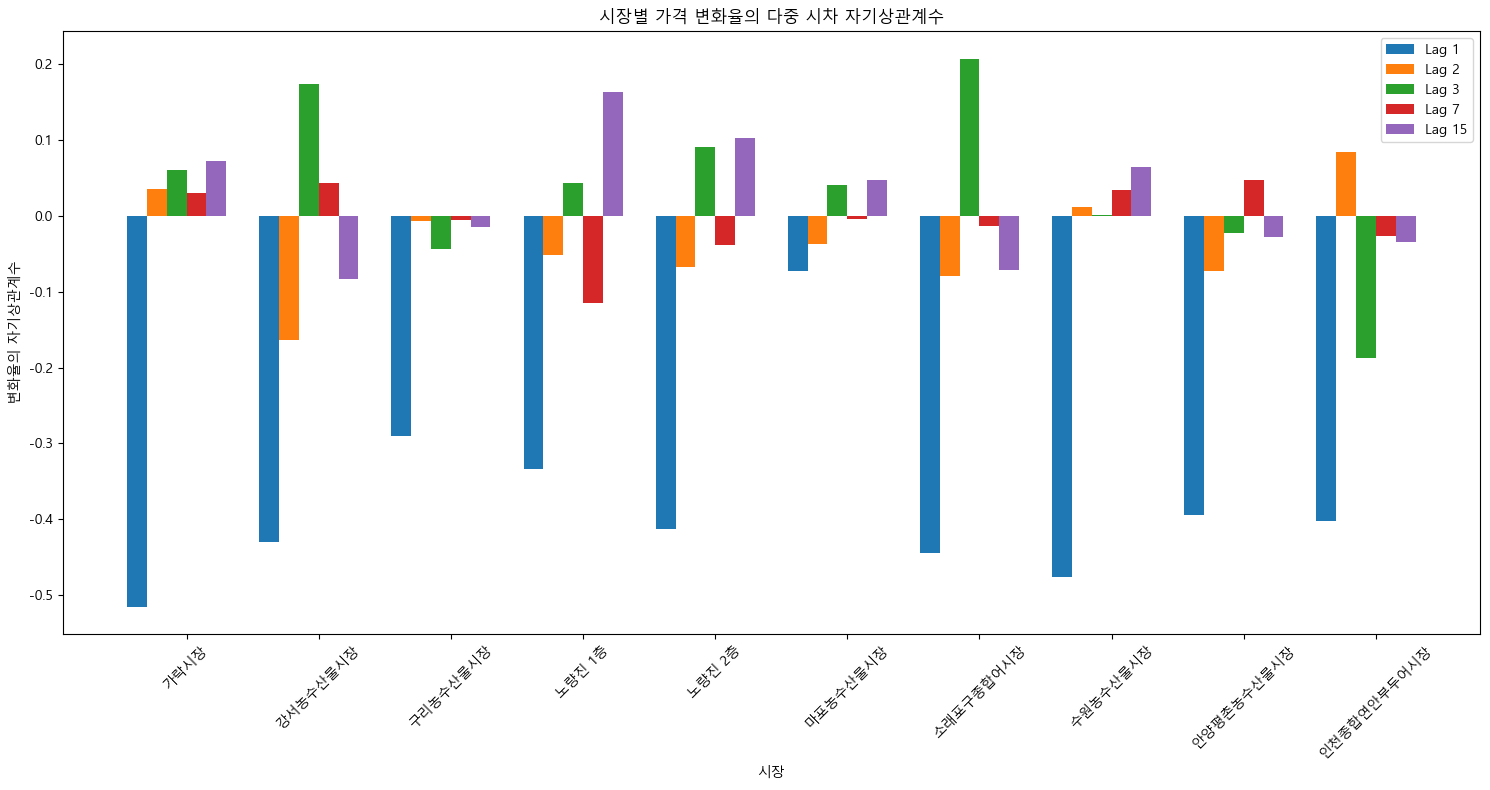

In [14]:

# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')

plt.xlabel('시장')
plt.ylabel('변화율의 자기상관계수')
plt.title('시장별 가격 변화율의 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

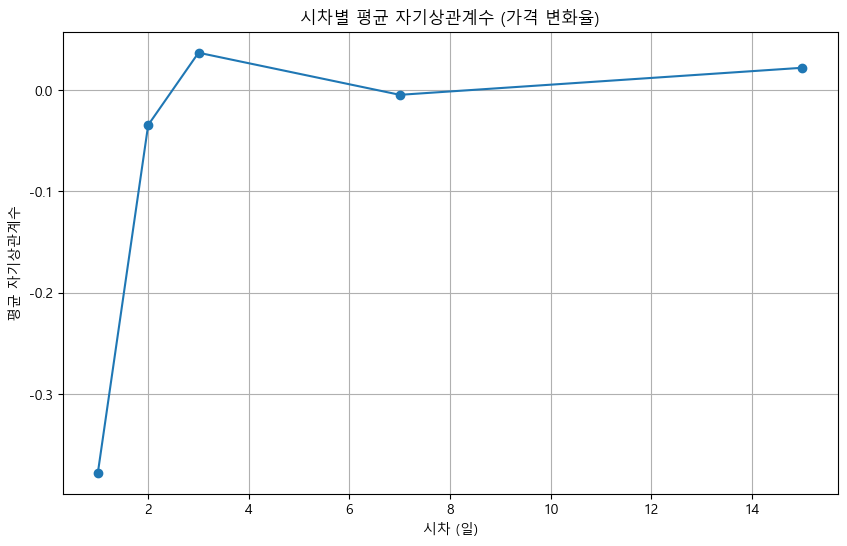

In [15]:


# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수 (가격 변화율)')
plt.grid(True)
plt.show()

### 결과 해석

* 시장 가격 절대값과 변화율 모두 높은 자기 상관계수를 보이는 것으로 보아, 시계열 의존성이 있다고 판단
* Durbin-Watson: 연속된 시점(lag 1)의 선형 관계만 검정이고 , Ljung-Box: 여러 시차에 걸친 비선형적 관계까지 포괄적으로 검정이기에 결과에 차이가 나타난다
* 의존성의 종류와 강도
	- 선형적 의존성은 약함 (Durbin-Watson으로 확인)
	- 비선형적 의존성은 존재 (Ljung-Box로 확인)
	- 복합적인 시차 관계가 존재할 수 있음

~결론~	시계열 의존성이 있다고 봐야 함    
단, 그 의존성은 단순한 선형관계가 아닐 수 있음  
특히 단기(1일) 반전 패턴과 함께 복잡한 패턴이 존재할 가능성

## 광어

### 시장별 가격 절대값의 시계열 의존성 확인

In [60]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [61]:

# CSV 읽기
df = pd.read_csv('광어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [62]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [63]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.000452
   강서농수산물시장       0.000861
   구리농수산물시장       0.001571
     노량진 1층       0.000676
     노량진 2층       0.000259
   마포농수산물시장       0.000073
부산민락어민활어직판장       0.000245
  소래포구종합어시장       0.000870
   수원농수산물시장       0.000489
 안양평촌농수산물시장       0.000262
인천종합연안부두어시장       0.000925

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.987487   0.984445   0.982732   0.974220    0.960512
   강서농수산물시장   0.986542   0.985101   0.985146   0.981158    0.972342
   구리농수산물시장   0.827112   0.787925   0.821130   0.823700    0.766932
     노량진 1층   0.960298   0.957554   0.953152   0.934576    0.909306
     노량진 2층   0.987117   0.987068   0.981364   0.973618    0.958034
   마포농수산물시장   0.996164   0.993565   0.991069   0.981291    0.958540
부산민락어민활어직판장   0.979005   0.973324   0.971049   0.956497    0.920419
  소래포구종합어시장   0

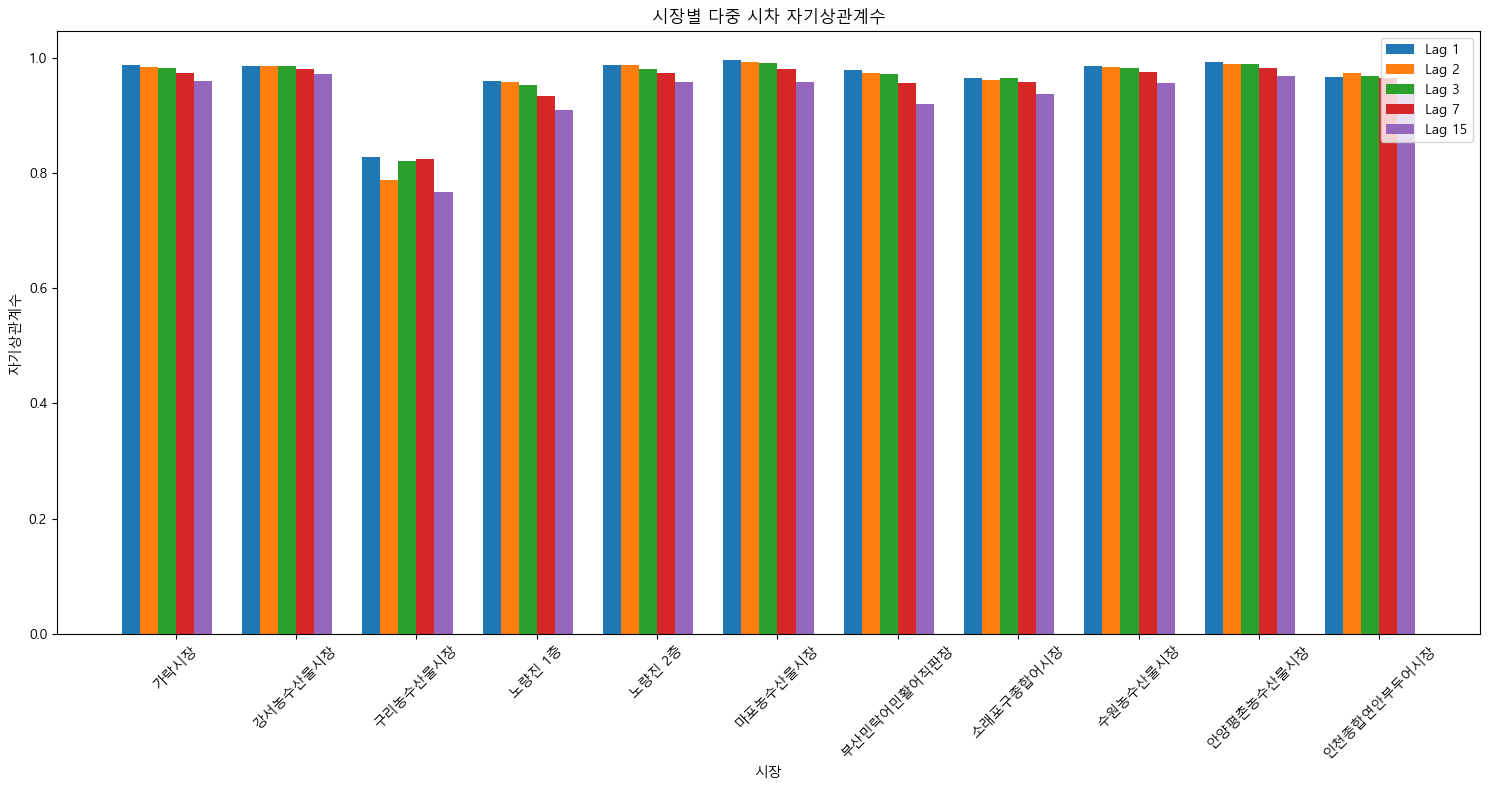

In [64]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

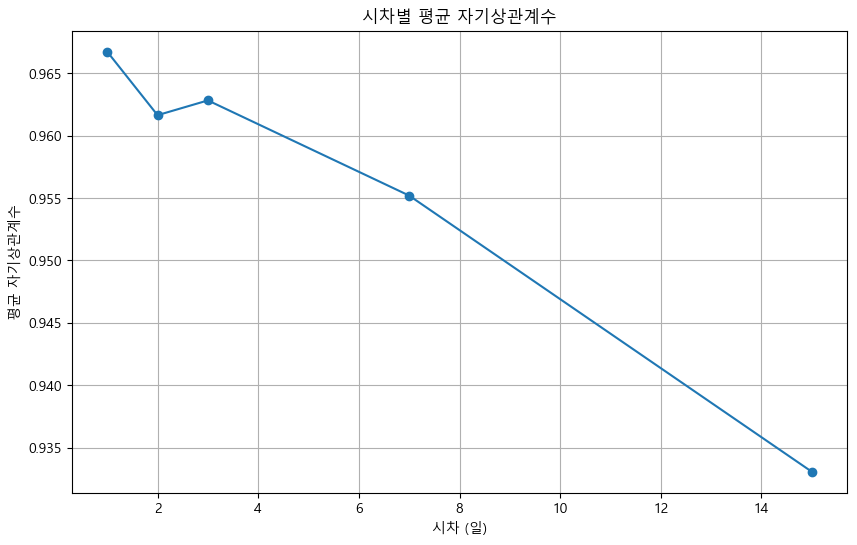

In [65]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

## 농어

### 시장별 가격 절대값의 시계열 의존성 확인

In [21]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [22]:

# CSV 읽기
df = pd.read_csv('농어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [23]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [24]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.000805
   강서농수산물시장       0.000722
   구리농수산물시장       0.000923
     노량진 1층       0.000391
     노량진 2층       0.000371
   마포농수산물시장       0.000152
  소래포구종합어시장       0.000677
   수원농수산물시장       0.000969
 안양평촌농수산물시장       0.000732
인천종합연안부두어시장       0.001489

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.984834   0.981009   0.980248   0.970761    0.956997
   강서농수산물시장   0.985833   0.984566   0.986424   0.981972    0.976985
   구리농수산물시장   0.975984   0.972709   0.971437   0.970858    0.954669
     노량진 1층   0.976427   0.965046   0.960477   0.939199    0.911932
     노량진 2층   0.987199   0.983001   0.981830   0.974883    0.960444
   마포농수산물시장   0.993762   0.987688   0.981859   0.958950    0.916317
  소래포구종합어시장   0.939782   0.930518   0.934289   0.925752    0.907050
   수원농수산물시장   0.962063   0.954835   0.9566

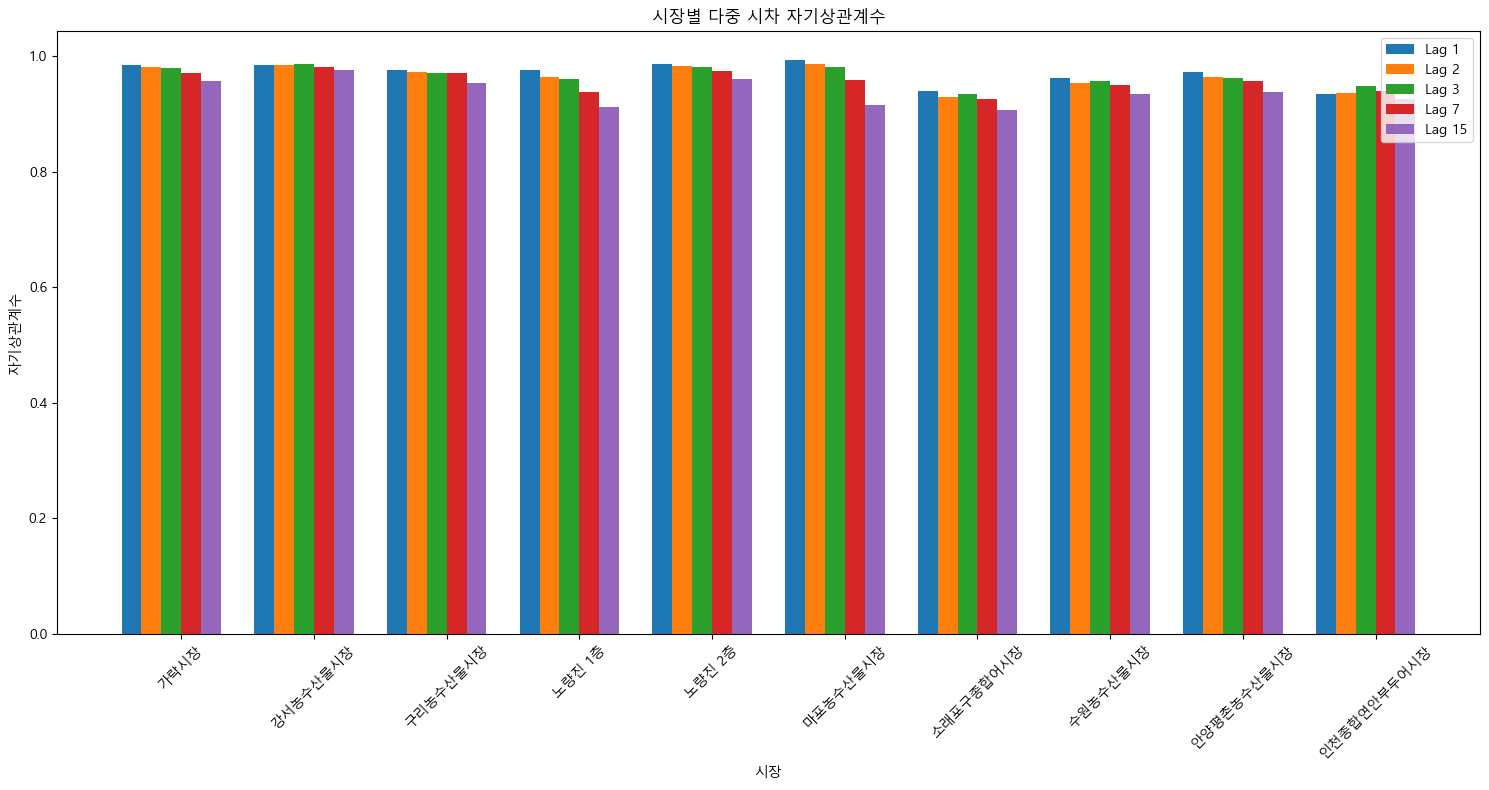

In [25]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

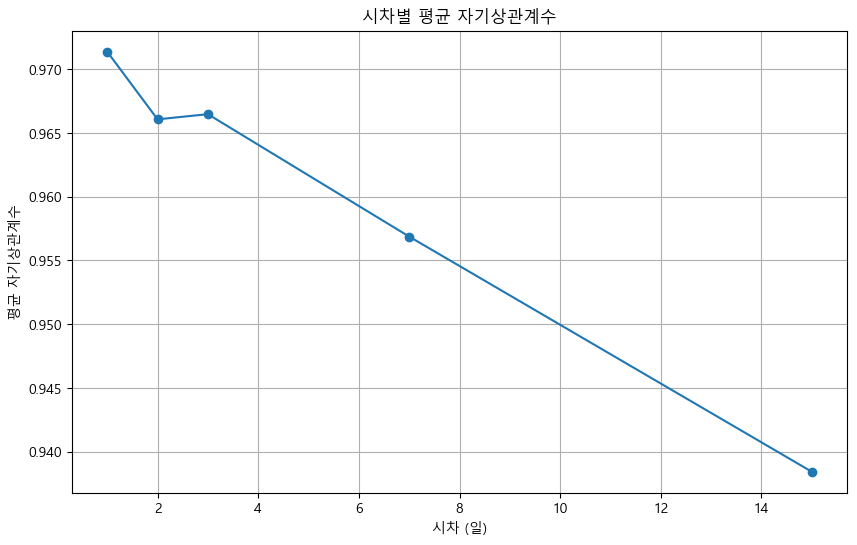

In [26]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

## 대게

### 시장별 가격 절대값의 시계열 의존성 확인

In [27]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [29]:

# CSV 읽기
df = pd.read_csv('대게_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [30]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [31]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.001902
   강서농수산물시장       0.000813
   구리농수산물시장       0.002310
     노량진 1층       0.002770
     노량진 2층       0.002511
  소래포구종합어시장       0.000492
   수원농수산물시장       0.000925
 안양평촌농수산물시장       0.000916
인천종합연안부두어시장       0.001138

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.980227   0.974973   0.972269   0.944698    0.888136
   강서농수산물시장   0.990271   0.980206   0.969849   0.919907    0.805101
   구리농수산물시장   0.978932   0.973037   0.966949   0.928671    0.842419
     노량진 1층   0.978193   0.961064   0.946968   0.893108    0.794518
     노량진 2층   0.980842   0.964288   0.949515   0.895830    0.797145
  소래포구종합어시장   0.990078   0.981874   0.973252   0.935998    0.857400
   수원농수산물시장   0.990581   0.982882   0.975144   0.940051    0.858442
 안양평촌농수산물시장   0.987065   0.974862   0.962781   0.909135    0.779559
인

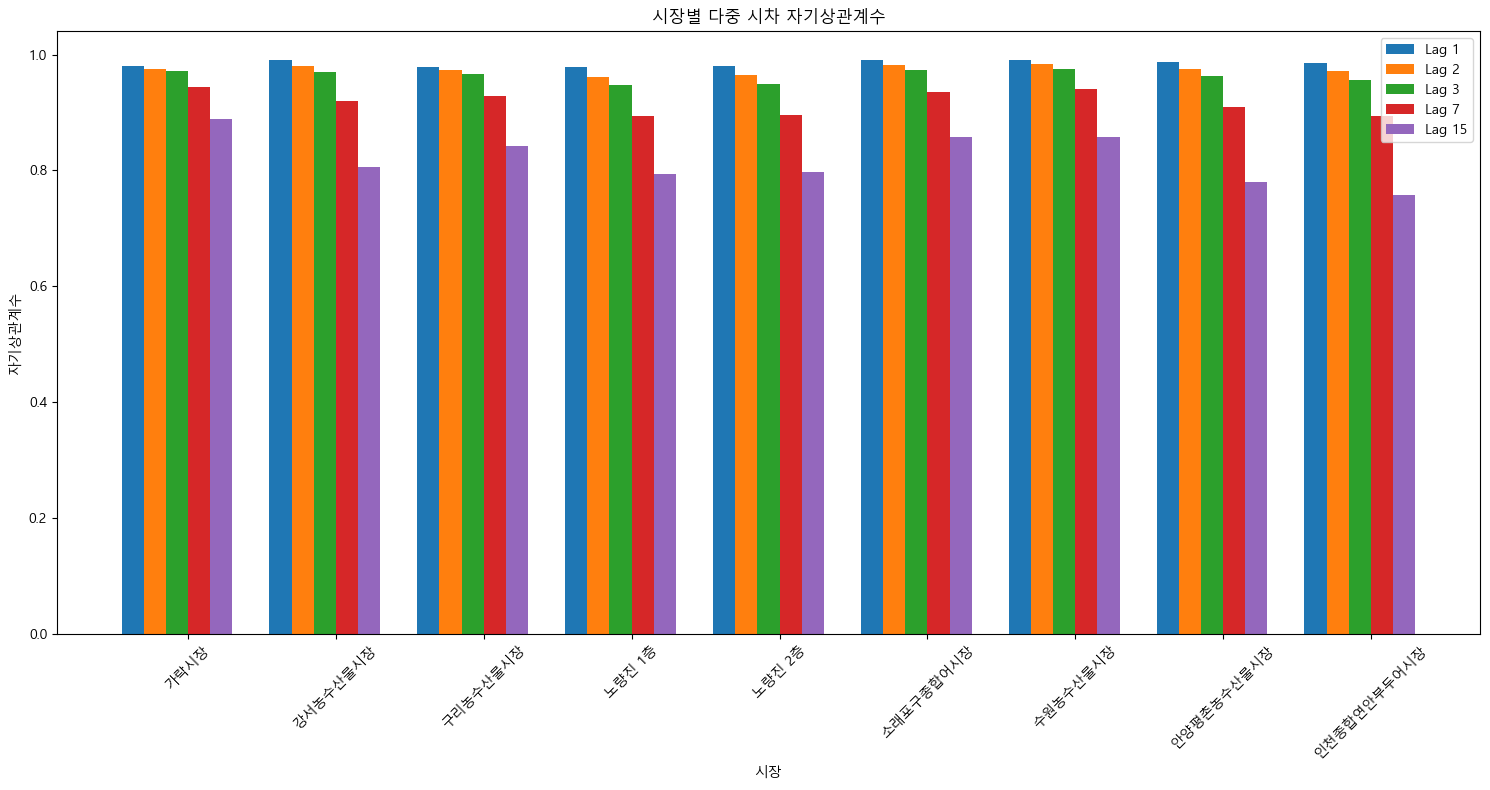

In [32]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

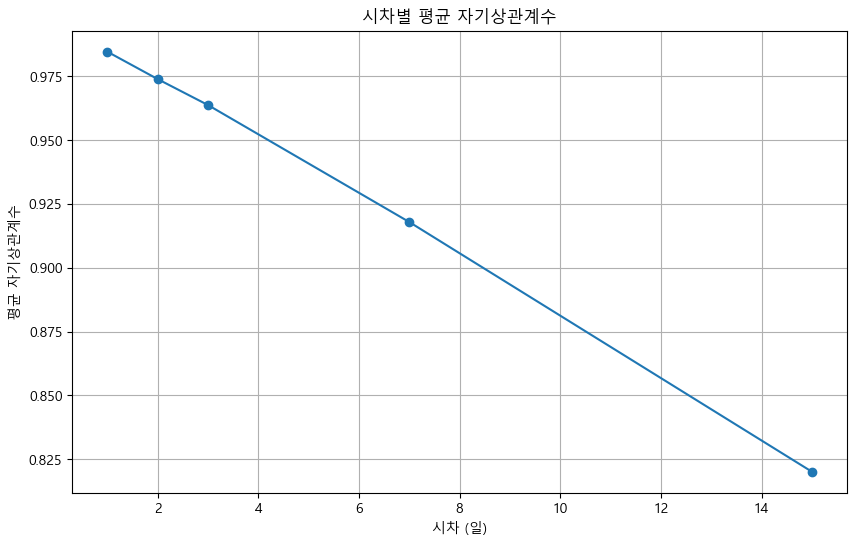

In [33]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

## 방어 

### 시장별 가격 절대값의 시계열 의존성 확인

In [55]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [56]:

# CSV 읽기
df = pd.read_csv('방어_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [57]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

c:\Users\user\miniconda3\envs\env311_cu121\Lib\site-packages\statsmodels\tsa\stattools.py:702: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


In [58]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.000452
   강서농수산물시장       0.000466
   구리농수산물시장       0.000287
     노량진 1층       0.002396
     노량진 2층       0.000839
부산민락어민활어직판장       0.000000
  소래포구종합어시장       0.000407
   수원농수산물시장       0.000558
인천종합연안부두어시장       0.000165

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.971592   0.957830   0.945059   0.896165    0.869430
   강서농수산물시장   0.988136   0.977375   0.966062   0.921364    0.839687
   구리농수산물시장   0.993640   0.987841   0.982754   0.963866    0.928912
     노량진 1층   0.978748   0.961704   0.948510   0.923622    0.893432
     노량진 2층   0.983854   0.972152   0.959188   0.912156    0.839925
부산민락어민활어직판장        NaN        NaN        NaN        NaN         NaN
  소래포구종합어시장   0.990145   0.988135   0.982365   0.968773    0.940763
   수원농수산물시장   0.994904   0.991163   0.987252   0.970480    0.939204
인

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (10,) and arg 1 with shape (9,).

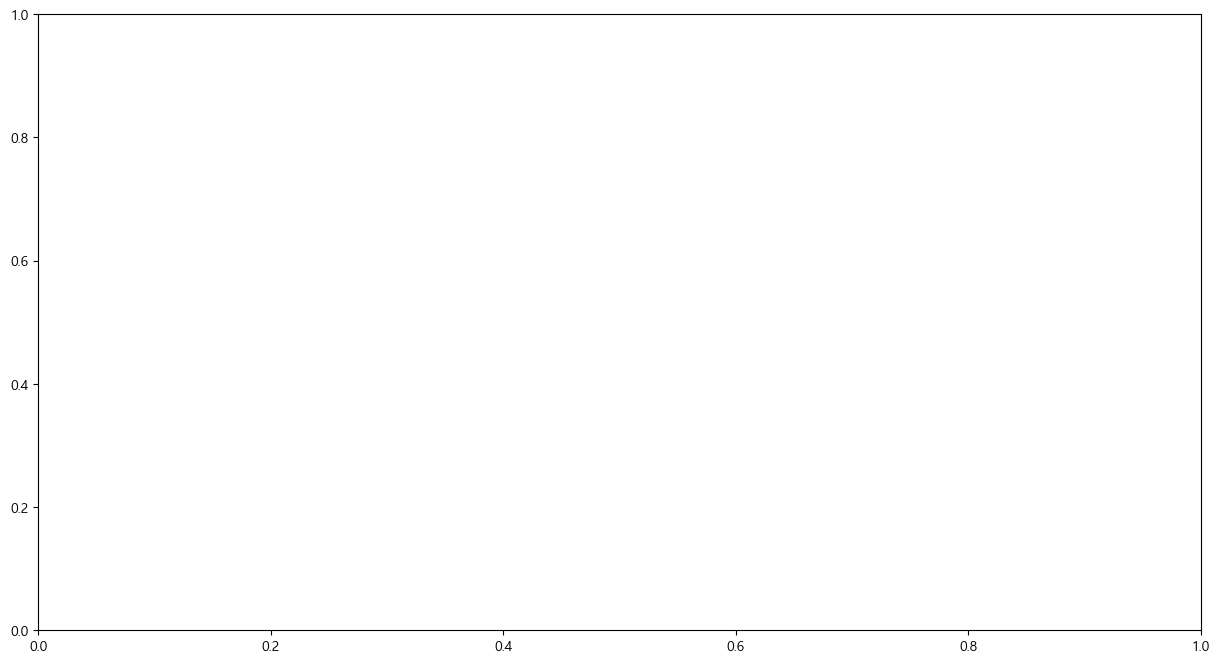

In [59]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

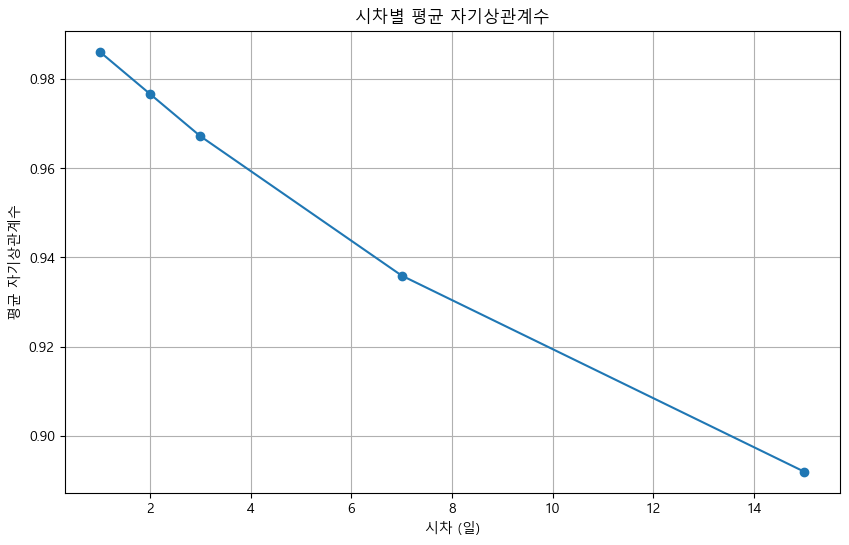

In [38]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

## 우럭

### 시장별 가격 절대값의 시계열 의존성 확인

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [39]:

# CSV 읽기
df = pd.read_csv('우럭_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [41]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [42]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.001707
   강서농수산물시장       0.001428
   구리농수산물시장       0.001063
     노량진 1층       0.000964
     노량진 2층       0.000757
   마포농수산물시장       0.000000
부산민락어민활어직판장       0.000227
  소래포구종합어시장       0.004129
   수원농수산물시장       0.001886
 안양평촌농수산물시장       0.001109
인천종합연안부두어시장       0.000633

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.475713   0.458625   0.380896   0.441639    0.347922
   강서농수산물시장   0.119001   0.118724   0.243717   0.222436    0.044646
   구리농수산물시장   0.778024   0.691343   0.663995   0.558631    0.325668
     노량진 1층   0.840597   0.813264   0.786164   0.786191    0.655938
     노량진 2층   0.754773   0.725836   0.732060   0.674074    0.576038
   마포농수산물시장        NaN        NaN        NaN        NaN         NaN
부산민락어민활어직판장   0.923886   0.928147   0.917090   0.894578    0.760733
  소래포구종합어시장   0

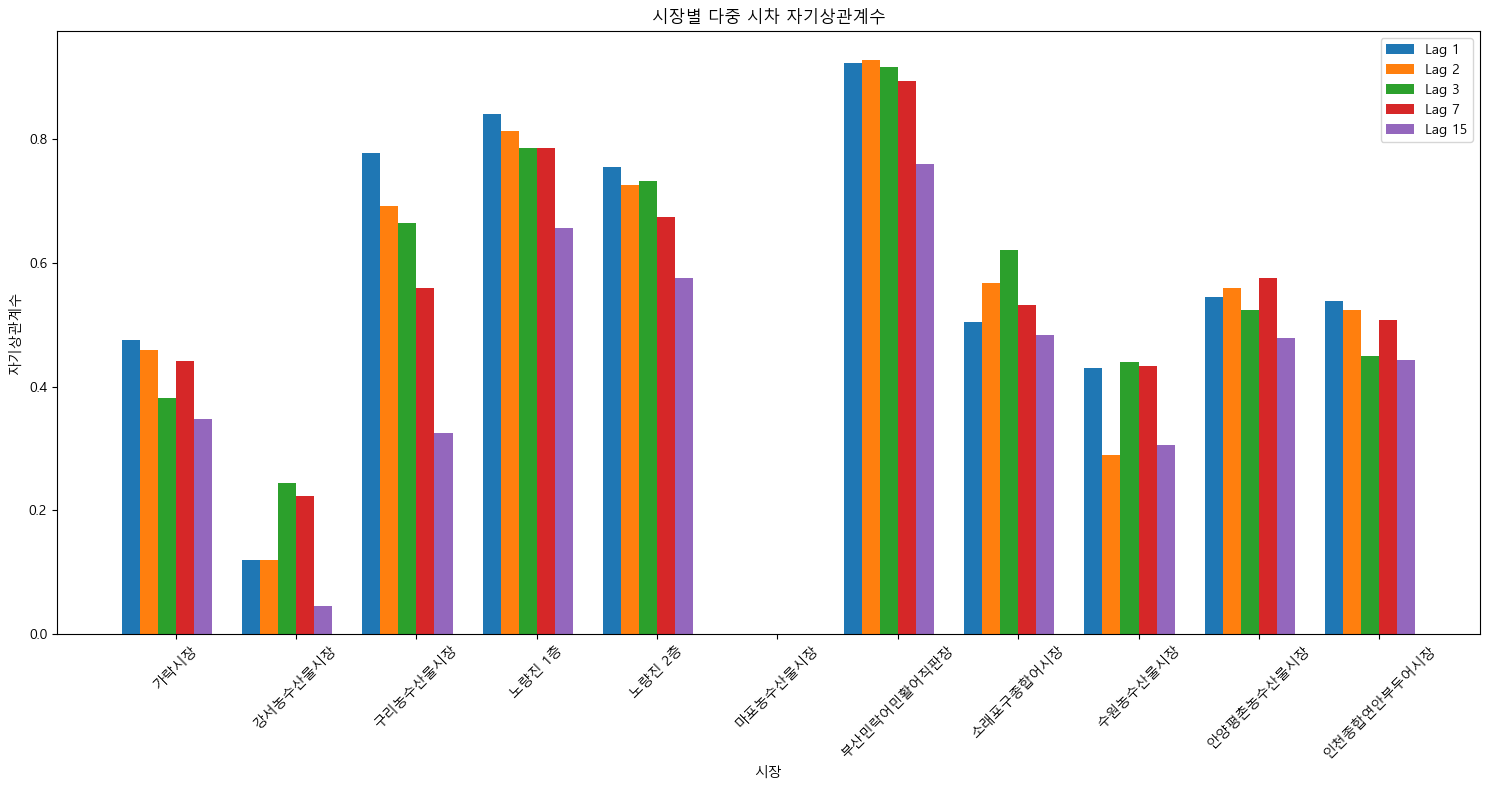

In [43]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

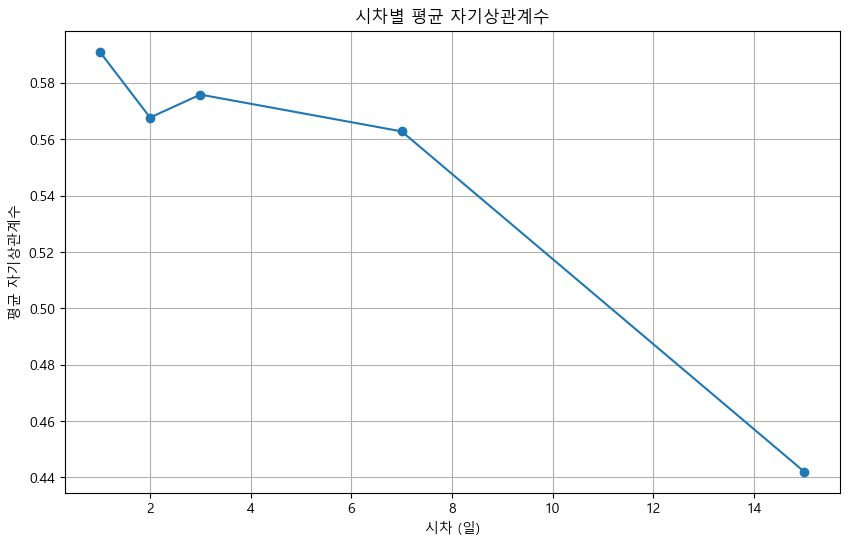

In [44]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

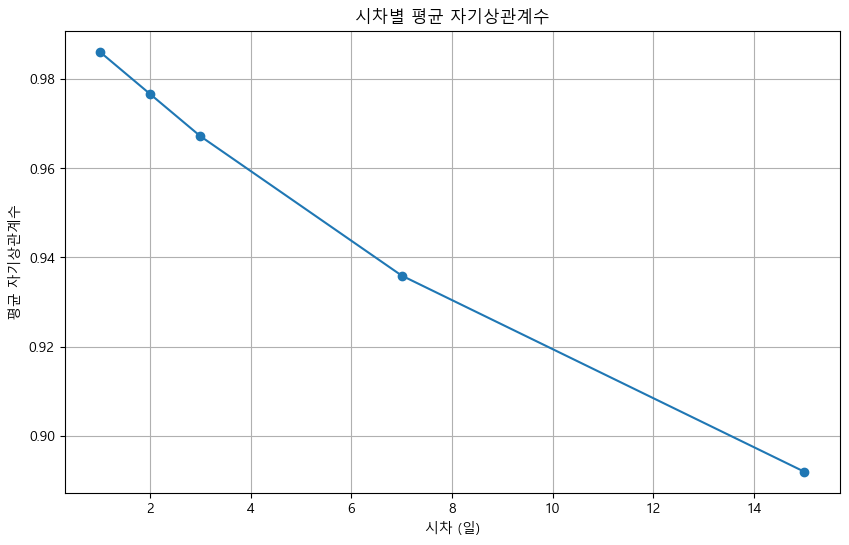

In [ ]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()

## 참돔 

### 시장별 가격 절대값의 시계열 의존성 확인

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.stattools import acf, q_stat
import matplotlib.pyplot as plt


#한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [45]:

# CSV 읽기
df = pd.read_csv('참돔_price_data.csv')

# 날짜 형식 변환
df['priceDate'] = pd.to_datetime(df['priceDate'])


In [46]:
# 분석할 시차들
lags = [1, 2, 3, 7, 15]

# 각 시장별로 분석
markets = df['market'].unique()
results = []

for market in markets:
    market_data = df[df['market'] == market].sort_values('priceDate')
    
    if len(market_data) < max(lags) + 1:
        continue
        
    # 1. Durbin-Watson 검정
    dw_stat = durbin_watson(market_data['avgPrice'].dropna())
    
    # 2. 자기상관계수
    acf_values = acf(market_data['avgPrice'].dropna(), nlags=max(lags))
    
    # 3. Ljung-Box 검정 (q_stat 사용)
    _, p_values = q_stat(acf_values[1:], len(market_data['avgPrice'].dropna()))
    lb_pvalues = p_values[np.array(lags)-1]  # lag에 해당하는 p-value만 선택
    
    result = {
        'market': market,
        'n_samples': len(market_data),
        'durbin_watson': dw_stat,
    }
    
    # 각 시차별 자기상관계수와 Ljung-Box p-value 추가
    for i, lag in enumerate(lags):
        result[f'acf_lag_{lag}'] = acf_values[lag]
        result[f'lb_pvalue_lag_{lag}'] = lb_pvalues[i]
    
    results.append(result)

In [47]:
# 결과를 데이터프레임으로 변환
results_df = pd.DataFrame(results)

print("\n=== 시장별 시계열 의존성 분석 결과 ===")
print("\n1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)")
print(results_df[['market', 'durbin_watson']].to_string(index=False))

print("\n2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)")
acf_columns = [col for col in results_df.columns if col.startswith('acf_lag_')]
print(results_df[['market'] + acf_columns].to_string(index=False))

print("\n3. 시차별 Ljung-Box 검정 p-value (0.05 미만이면 시계열 의존성이 있다고 판단)")
lb_columns = [col for col in results_df.columns if col.startswith('lb_pvalue_')]
print(results_df[['market'] + lb_columns].to_string(index=False))


=== 시장별 시계열 의존성 분석 결과 ===

1. Durbin-Watson 통계량 (2에 가까울수록 독립적, 0 또는 4에 가까울수록 의존적)
     market  durbin_watson
       가락시장       0.000500
   강서농수산물시장       0.000656
   구리농수산물시장       0.000029
     노량진 1층       0.000274
     노량진 2층       0.000085
   마포농수산물시장       0.000162
  소래포구종합어시장       0.000571
   수원농수산물시장       0.000706
 안양평촌농수산물시장       0.000217
인천종합연안부두어시장       0.000026

2. 시차별 자기상관계수 (절대값이 클수록 의존성이 강함)
     market  acf_lag_1  acf_lag_2  acf_lag_3  acf_lag_7  acf_lag_15
       가락시장   0.972672   0.966278   0.963251   0.958198    0.946671
   강서농수산물시장   0.982620   0.982543   0.982166   0.977940    0.970233
   구리농수산물시장   0.994772   0.989751   0.984731   0.968367    0.943075
     노량진 1층   0.957321   0.946293   0.930129   0.899415    0.853954
     노량진 2층   0.987568   0.984052   0.980961   0.969634    0.947413
   마포농수산물시장   0.947027   0.923313   0.905225   0.818243    0.648782
  소래포구종합어시장   0.926540   0.920868   0.928604   0.907870    0.877979
   수원농수산물시장   0.968085   0.961051   0.9603

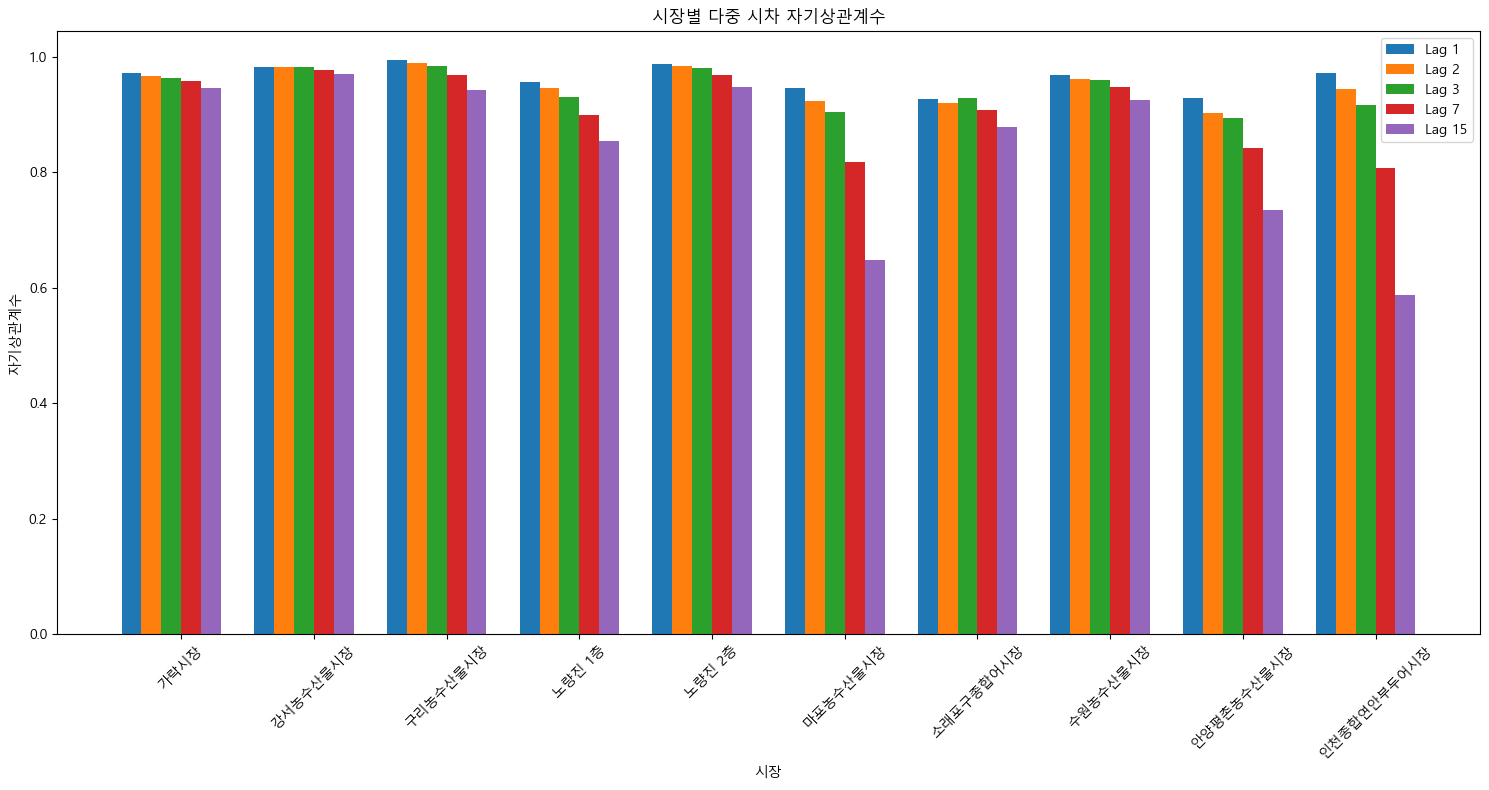

In [48]:
# 각 시장별 자기상관계수 시각화
plt.figure(figsize=(15, 8))
width = 0.15
x = np.arange(len(markets))

for i, lag in enumerate(lags):
    plt.bar(x + width * (i - len(lags)/2), 
            results_df[f'acf_lag_{lag}'], 
            width, 
            label=f'Lag {lag}')
    

plt.xlabel('시장')
plt.ylabel('자기상관계수')
plt.title('시장별 다중 시차 자기상관계수')
plt.xticks(x, markets, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

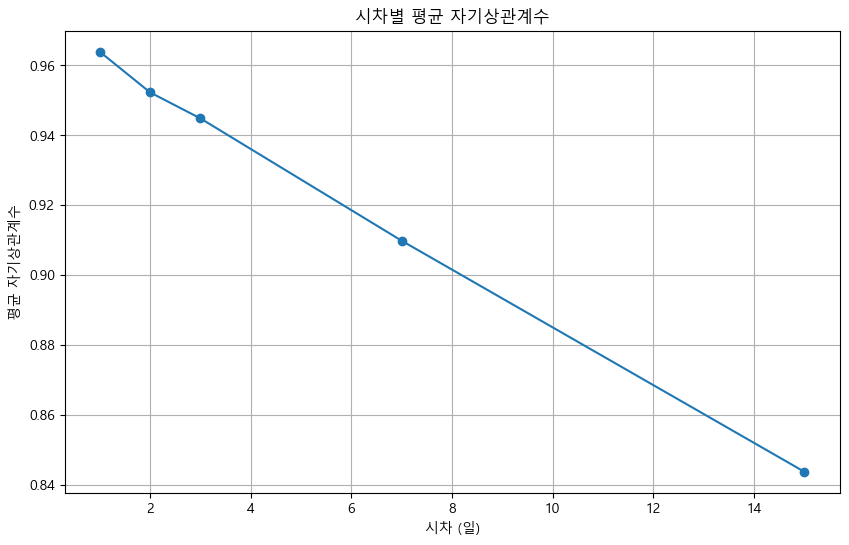

In [49]:
# 시차별 자기상관계수 평균 비교
acf_means = [results_df[f'acf_lag_{lag}'].mean() for lag in lags]
plt.figure(figsize=(10, 6))
plt.plot(lags, acf_means, marker='o')
plt.xlabel('시차 (일)')
plt.ylabel('평균 자기상관계수')
plt.title('시차별 평균 자기상관계수')
plt.grid(True)
plt.show()